In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from wordcloud import WordCloud, ImageColorGenerator
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
stopwords_list = stopwords.words('english')
newStopWords = stopwords.words('spanish')
stopwords_list.extend(newStopWords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
tweets1_1 = pd.read_csv("./data/hashtag_donaldtrump.csv", lineterminator="\n")
tweets1_2 = pd.read_csv("./data/hashtag_joebiden.csv", lineterminator="\n")
tweets2_1 = pd.read_csv("./data/2020-US-election-tweets.csv", sep=",")
tweets = pd.DataFrame()

In [3]:
def clean(tweet):
    """ La funcion elimina los caracteres especiales, links, saltos de linea, tabulaciones, signos de puntuacion ... 
        
        args:
            tweet (): str
        return : str
    """
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@|\#','', tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub(r'[^a-z0-9|^\\s ]','', tweet)
    tweet_tokens = word_tokenize(tweet)
    tweet_tokens = [t for t in tweet_tokens if len(t) > 1]
    filtered_words = [w for w in tweet_tokens if not w in stopwords_list]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    
    return " ".join(lemma_words)

In [4]:
tweets2_1 = tweets2_1[tweets2_1.language == 'en']
tweets2_1.tweet = tweets2_1.tweet.apply(lambda x: clean(x))
tweets1_1.tweet = tweets1_1.tweet.apply(lambda x: clean(x))
tweets1_2.tweet = tweets1_2.tweet.apply(lambda x: clean(x))

In [5]:
def parser (tweet, likes, retweets, date):
    """ La funcion estandariza los tipos de datos con los que se va a trabajar ... 
        args:
            tweet (): object
            likes(): numeric
            retweets(): numeric
            date (): object
        return : DataFrame
    """
    df = pd.DataFrame({'tweet': tweet.astype(str), 
                       'likes':likes.astype('int64'), 
                       'retweets': retweets.astype('int64'), 
                       'date': pd.to_datetime(date, errors='coerce').dt.date})
    return df    

In [6]:
tweets = tweets.append(parser(tweets1_1['tweet'], tweets1_1['likes'], tweets1_1['retweet_count'], tweets1_1['created_at']))
tweets = tweets.append(parser(tweets1_2['tweet'], tweets1_2['likes'], tweets1_2['retweet_count'], tweets1_2['created_at']))
tweets = tweets.append(parser(tweets2_1['tweet'], tweets2_1['likes_count'], tweets2_1['retweets_count'], tweets2_1['date']))
tweets[tweets.tweet.isnull()]

,tweet,likes,retweets,date


In [7]:
tweets.to_csv("./data/tweets.csv", sep=',', index=False)

In [8]:
def flatten(l):
    """ La funcion aplana una lista de listas 
        
        args:
            l (): lista de listas
        return : lista aplanada
    """
    return [item for sublist in l for item in sublist]

In [9]:
#Calculamos la frecuencia de cada palabra
tweets_words = tweets.tweet.apply(lambda x: word_tokenize(x))
flatten_tweets_words = flatten(tweets_words)
word_freq = nltk.FreqDist(flatten_tweets_words)
print (word_freq.most_common(50))

[('trump', 1196377), ('biden', 807034), ('election2020', 428864), ('joebiden', 413709), ('vote', 170094), ('donaldtrump', 163137), ('realdonaldtrump', 151593), ('election', 145077), ('amp', 139423), ('president', 124038), ('us', 108767), ('elections2020', 96261), ('joe', 91618), ('usa', 88160), ('like', 87983), ('america', 86481), ('bidenharris2020', 83300), ('people', 82691), ('trump2020', 74378), ('votes', 70355), ('electionday', 63584), ('dont', 60862), ('kamalaharris', 60840), ('get', 60437), ('covid19', 59902), ('2020', 59256), ('good', 56892), ('win', 56825), ('donald', 56619), ('electionresults2020', 55718), ('one', 55369), ('would', 52743), ('im', 51904), ('trumps', 48905), ('time', 48550), ('maga', 48447), ('know', 47616), ('going', 47494), ('georgia', 47162), ('die', 44424), ('news', 44214), ('go', 44113), ('states', 41066), ('cnn', 41024), ('elections', 40725), ('biden2020', 39470), ('see', 38935), ('new', 38661), ('democrats', 38462), ('think', 38161)]


In [10]:
def tuple2array(value):
    """ La funcion convierte una tupla a un arrau
        
        args:
            value: tupla
        return : lista: array() 
    """
    lista = []
    for a_tuple in value:
        lista.append(a_tuple[0])
    return lista 

Text(0.5, 1.0, 'Top 20 palabras más frecuentes')

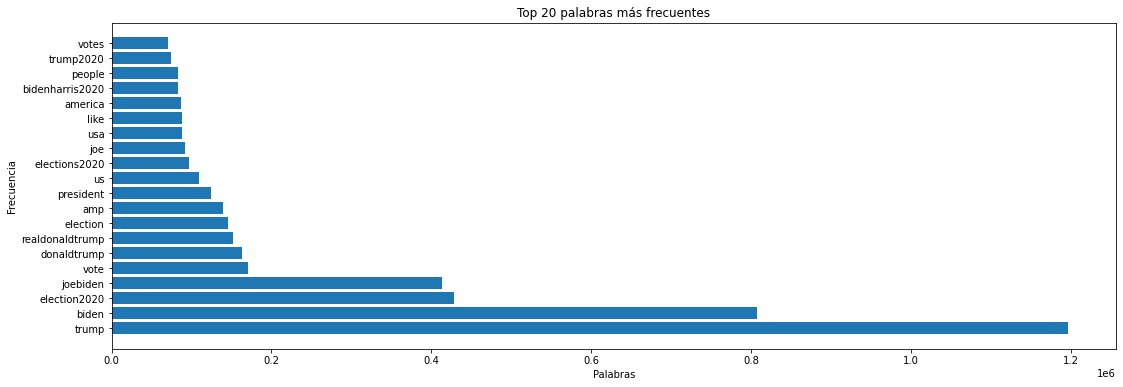

In [11]:
common_words = word_freq.most_common(20)
words = []
freq = []
for i in common_words:
    words.append(i[0])
    freq.append(i[1])
plt.figure(figsize=(18,6))
plt.barh(words, freq)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title("Top 20 palabras más frecuentes")

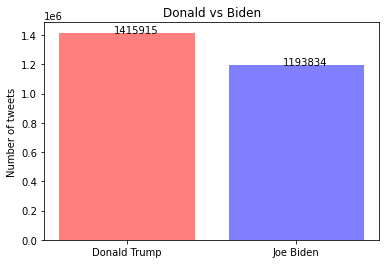

In [12]:
# Numero de tweets que menciona Donald Trump -- grafico de barras
trump_tweets = tweets[tweets.tweet.str.contains(pat='trump', case=False)]
biden_tweets = tweets[tweets.tweet.str.contains(pat='biden', case=False)]

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [trump_tweets.shape[0],biden_tweets.shape[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5,color=['red', 'blue'])
for c, value in enumerate(performance): 
    plt.text(c-0.08, value, str(value)) 

plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald vs Biden')

plt.show()

In [13]:
# Cantidad de menciones a traves del tiempo para cada candidato-- grafico de lineas
trump_tweets['date2'] = trump_tweets['date'].apply(lambda d: str(d.day)+"-"+str(d.month))
biden_tweets['date2'] = biden_tweets['date'].apply(lambda d: str(d.day)+"-"+str(d.month))
mencions_month_trump = trump_tweets.groupby(trump_tweets['date2']).apply(lambda x: pd.Series({
        'trump': x.tweet.count()
}))
mencions_month_biden = biden_tweets.groupby(biden_tweets['date2']).apply(lambda x: pd.Series({
        'biden': x.tweet.count()
}))

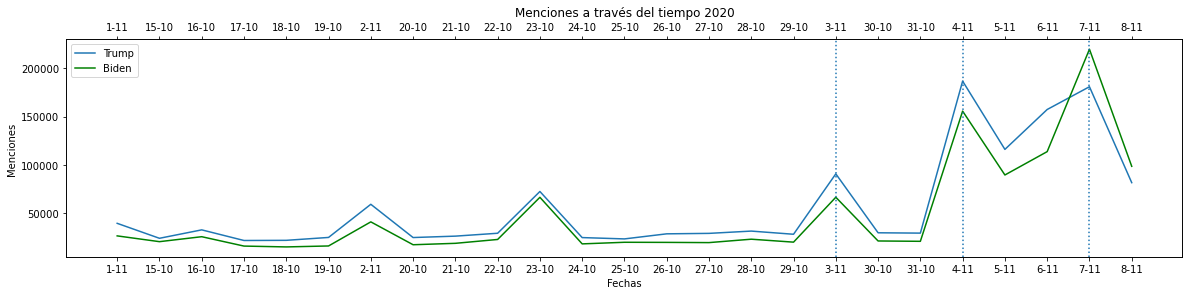

In [14]:
fig, ax1 = plt.subplots(figsize= (20,4))
 
plot1, = ax1.plot(mencions_month_trump, label="Trump")
#Para poder realizar ambos plots en uno pero con diferentes escalas en el eje x, usamos twiny que nos permite compartir el eje y
ax2 = ax1.twiny()
plot2, = ax2.plot(mencions_month_biden, color='g', label="Biden")
ax1.set_title("Menciones a través del tiempo 2020")
ax1.set_xlabel("Fechas")
ax1.set_ylabel("Menciones")
plt.axvline("3-11", ls=":")
plt.axvline("4-11", ls=":")
plt.axvline("7-11", ls=":")
plt.legend(loc="upper left", handles=[plot1, plot2])
plt.show()

En el gráfico podemos observar que uno de los picos más importantes, que representan un aumento en las menciones de Trump y Biden se dió el 3 de noviembre que fue el día de las elecciones. Seguidamente, el 4 de noviembre el presidente de Estados Unidos, Donald Trump, escribió en su cuenta de twitter acerca de un supuesto fraude electoral, gracias a este acontecimiento podemos observar que las menciones incrementaron. Finalmente el 7 de noviembre se dieron a conocer los resultados de las elecciones, razón por la cual podemos observar que las menciones a Biden superaron a las de Trump. 

In [15]:
def word_cloud(wd_list):
    """ La funcion grafica la cantidad de ocurrencias con mayor repeticion ... 
        
        args:
            wd_list (): pd.Series
            qtty (): int
        return : none
    """
    dic = {}
    for index, value in wd_list:
        dic[index] = value
    wordcloud = WordCloud( background_color='white',
        width=1600,
        height=800)
    wordcloud.generate_from_frequencies(frequencies=dic)
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

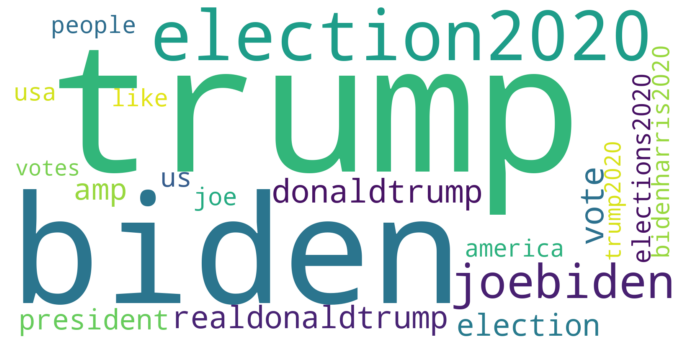

In [16]:
# Las 20 Palabras mas comunes
word_cloud(common_words)

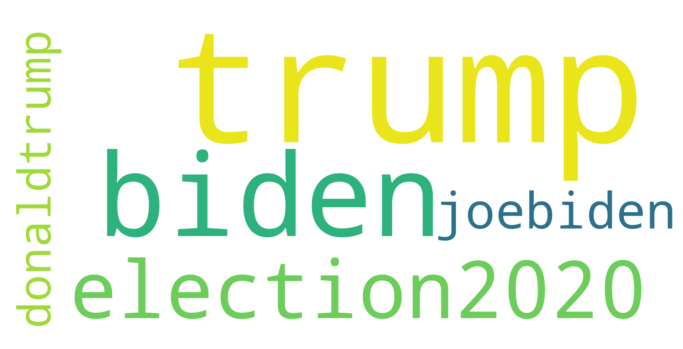

In [17]:
# 5 Palabras mas comunes para Donald Trump -- imshow
trump_words = trump_tweets.tweet.apply(lambda x: word_tokenize(x))
flatten_tweets_words = flatten(trump_words)
word_freq = nltk.FreqDist(flatten_tweets_words)
common_words = word_freq.most_common(5)
word_cloud(common_words)

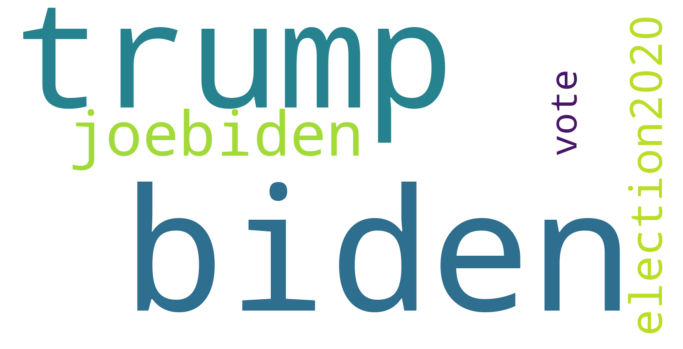

In [18]:
# 5 Palabras mas comunes para Donald Trump -- imshow
biden_words = biden_tweets.tweet.apply(lambda x: word_tokenize(x))
flatten_tweets_words = flatten(biden_words)
word_freq = nltk.FreqDist(flatten_tweets_words)
common_words = word_freq.most_common(5)
word_cloud(common_words)